In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import astropy.io.ascii as ascii
import time
from scipy.optimize import curve_fit

#np.random.seed(666)

## Name of galaxy

In [2]:
#galaxy='IC5332'
#galaxy='NGC0628'
#galaxy='NGC1087'
#galaxy='NGC1365' 
#galaxy='NGC1512'
#galaxy='NGC1672'
#galaxy='NGC2835'
#galaxy='NGC3351'
galaxy='NGC3627'
#galaxy='NGC5068'


## Function that calculates the 2-point cross-correlation function

In [3]:
def w(x1, y1, x2, y2, xr, yr, rmin=0, rmax=5000, dr=25):

    ddarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([x2,y2]))).ravel()  
    drarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([xr,yr]))).ravel()

    # Count pairs in distance bins       
    N1=len(x1)
    N2=len(x2)
    Nr=len(xr)
    bins=np.arange(rmin+dr/2, rmax, dr) # centers of bins for output

    dd0, dd0bins = np.histogram(ddarr, bins=np.arange(rmin, rmax+dr, dr)) #here bins are bin edges
    dr0, dr0bins = np.histogram(drarr, bins=np.arange(rmin, rmax+dr, dr))
    
    # Normalize pair counts and compute cross-correlation function
    dd=dd0/N1/N2
    dr=dr0/N1/Nr
    omega=dd/dr-1
    
    edd=np.sqrt(dd0)/N1/N2
    edr=np.sqrt(dr0)/N1/Nr

    eomega=np.sqrt((edd/dr)**2+(dd*edr/dr**2)**2)

    return (bins, omega, eomega)


## Functions that draws N model GMCs and returns properties

In [4]:
# This version just uses the observed GMC coordinates and assumes constant parameters for all clouds

def drawgmc_xy(x,y,rc=25,tc=30,ts=10,tfb=5,Ng=1,voff=10):

    ngmc=len(x) # number of GMCs
    
    xgmc=x # gmc x coordinates [pc]
    ygmc=y # gmc y coordinates [pc]
    
    rc=np.repeat(rc,ngmc) # gmc radius [pc]
    tc=np.repeat(tc,ngmc) # gmc lifetime [Myr]
    ts=np.repeat(ts,ngmc) # stellar SF tracer lifetime [Myr]
    tfb=np.repeat(tfb,ngmc) # stellar SF tracer emergence time [Myr]
    Ng=np.repeat(Ng,ngmc).astype(int) # number of massive SF episodes during gmc lifetime
    voff=np.repeat(voff,ngmc) # stellar SF tracer centorid to GMC centroid offset speed [km/s]

    tobs=np.random.uniform(0, tc-tfb+ts, ngmc) # random observation time for this cloud (between zero and tc+ts)
    fgmc=np.repeat(True, ngmc) # GMC visibility flag
    fgmc[tobs > tc]=False # visibility flag is False if GMC has faded

    return (xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc)
    

In [5]:
# This version samples GMC coordinates with a typical separation scale "l" within a 2x2 kpc box, and assumes constant parameters for all clouds
# Also returns random catalog coordinates over the same area and Frand*Ngmc points
def drawgmc_l(dbox=2000,l=200,rc=25,tc=30,ts=10,tfb=5,Ng=1,voff=10, frand=10):

    area=dbox**2
    ngmc=int(area/l**2) # number of GMCs
    
    xgmc=np.random.uniform(-0.5*dbox, 0.5*dbox, ngmc) # gmc x coordinates [pc]
    ygmc=np.random.uniform(-0.5*dbox, 0.5*dbox, ngmc) # gmc y coordinates [pc]

    xr=np.random.uniform(-0.5*dbox, 0.5*dbox, frand*ngmc) # gmc x coordinates [pc]
    yr=np.random.uniform(-0.5*dbox, 0.5*dbox, frand*ngmc) # gmc y coordinates [pc]

    
    rc=np.repeat(rc,ngmc) # gmc radius [pc]
    tc=np.repeat(tc,ngmc) # gmc lifetime [Myr]
    ts=np.repeat(ts,ngmc) # stellar SF tracer lifetime [Myr]
    tfb=np.repeat(tfb,ngmc) # stellar SF tracer emergence time [Myr]
    Ng=np.repeat(Ng,ngmc).astype(int) # number of massive SF episodes during gmc lifetime
    voff=np.repeat(voff,ngmc) # stellar SF tracer centorid to GMC centroid offset speed [km/s]

    tobs=np.random.uniform(0, tc-tfb+ts, ngmc) # random observation time for this cloud (between zero and tc+ts)
    fgmc=np.repeat(True, ngmc) # GMC visibility flag
    fgmc[tobs > tc]=False # visibility flag is False if GMC has faded

    print("Generating GMC and random coordinates:", ngmc, frand*ngmc)
    return (xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc, xr, yr)
    

## Function that draws N*Ng HII regions given an ensemble of GMCs

In [6]:
def drawhii(xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc):
    
    ngmc=len(xgmc) # number of GMCs
    nhii=np.sum(Ng.astype(int)) # number of HII regions
    voffaux=voff*3.2e-14*(1e6*365*24*3600) # velocity in pc/Myr


    xhii=np.zeros(nhii) # HII region initial coordinates
    yhii=np.zeros(nhii)
    t0=np.zeros(nhii) # HII region formation time
    fhii=np.repeat(False,nhii) # HII region visibility flag
    indgmc=np.zeros(nhii) # gmc list index

    
    k=0 # counter
    for i in range(ngmc):
        for j in range(Ng[i]):

            # initial position
            r0=rc[i]*np.sqrt(np.random.uniform(0,1)) # uniform across circular area
#            r0=rc[i]*np.random.uniform(0,1) # uniform in radius (i.e. as r**-2)
            theta0=np.random.uniform(0, 2*np.pi)
            x0=xgmc[i]+r0*np.cos(theta0)
            y0=ygmc[i]+r0*np.sin(theta0)

            #formation time
            t0[k]=np.random.uniform(0, tc[i]-tfb[i])    
            
            #offset direction and final position at tobs
            phi=np.random.uniform(0, 2*np.pi)
            xhii[k]=x0+voffaux[i]*(tobs[i]-t0[k])*np.cos(phi)
            yhii[k]=y0+voffaux[i]*(tobs[i]-t0[k])*np.sin(phi)

            #visibility flag is True if cloud has already formed and emerged, and has not yet faded
            if (t0[k]+tfb[i]<tobs[i])*(tobs[i]<t0[k]+ts[i]):
                fhii[k]=True

                #print(t0[k], tfb[i], ts[i], tobs[i], t0[k]+tfb[i], t0[k]+ts[i], fhii[k])
            
            #GMC list index
            indgmc=i
            
            k=k+1
        
    
    return (xhii,yhii,fhii)
    
    
    

## Read GMC and Random catalogs coordinates

In [7]:
xygmc=ascii.read('./output/'+galaxy+'_xy_gmc.txt')
x1=xygmc['col0'].data
y1=xygmc['col1'].data

xyrand=ascii.read('./output/'+galaxy+'_xy_rand.txt')
xr=xyrand['col0'].data
yr=xyrand['col1'].data


## Read Observed Correlation Function

In [8]:
obscorr=ascii.read('./output/'+galaxy+'_corr.txt')
r0obs=obscorr['col0'].data
w0obs=obscorr['col1'].data
ew0obs=obscorr['col2'].data

## Test Model

Generating GMC and random coordinates: 1111 11110
Run Time [s] = 1.146460771560669
Generating GMC and random coordinates: 1111 11110
Run Time [s] = 2.2837159633636475
Generating GMC and random coordinates: 1111 11110
Run Time [s] = 3.4134697914123535
Generating GMC and random coordinates: 1111 11110
Run Time [s] = 4.539682865142822
Generating GMC and random coordinates: 1111 11110
Run Time [s] = 5.595411777496338
Generating GMC and random coordinates: 1111 11110
Run Time [s] = 6.613810777664185
Generating GMC and random coordinates: 1111 11110
Run Time [s] = 7.629587888717651
Generating GMC and random coordinates: 1111 11110
Run Time [s] = 8.66159987449646
Generating GMC and random coordinates: 1111 11110
Run Time [s] = 9.67811393737793
Total Run Time [s] = 9.678354024887085


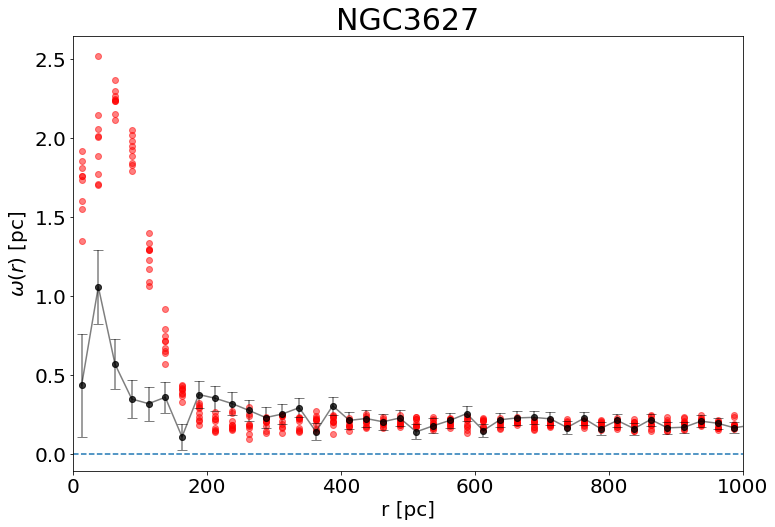

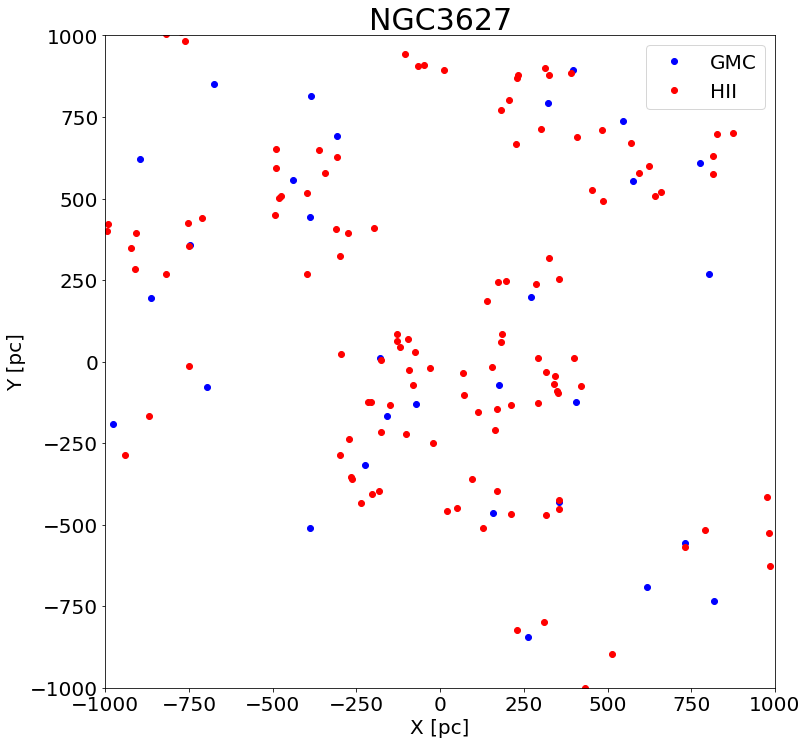

In [22]:
t0=time.time()

fig, ax = plt.subplots(figsize=(12, 8))

for i in range(9):

#    xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc = drawgmc_xy(x1, y1, rc=20,tc=100,ts=10,tfb=4,Ng=1,voff=10)
    IC=0.2
    xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc, xr, yr = drawgmc_l(dbox=10000, l=300, rc=50,tc=20,ts=15,tfb=4,Ng=10,voff=10,frand=10)
    xhii, yhii, fhii = drawhii(xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc)
    r0, w0, ew0 = w(xgmc[fgmc], ygmc[fgmc], xhii[fhii], yhii[fhii], xr, yr, rmax=1000)
    w0=w0+IC
    

    

#    print(w0)
    
#    w0=w0/12
#    ew0=ew0/12
    
    #ax.errorbar(r0, w0, ew0, fmt="-o", color='red', capsize=5, alpha=0.5)
    ax.plot(r0, w0, 'o', color='red', alpha=0.5)
    print("Run Time [s] =", time.time()-t0)

print("Total Run Time [s] =", time.time()-t0)


ax.errorbar(r0obs, w0obs, ew0obs, fmt="o", color='black', capsize=5, alpha=0.5)
ax.plot(r0obs, w0obs, '-o', color='black', alpha=0.5)
ax.set_xlim(0, 1000)
ax.axhline(y=0, linestyle='--')
ax.set_xlabel('r [pc]', fontsize=20)
ax.set_ylabel(r'$\omega(r)$ [pc]', fontsize=20)
ax.set_title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
#ax.set_yscale('log')
plt.savefig('./plots/'+galaxy+'_corr_model.png')
#plt.show()


fig, ax = plt.subplots(figsize=(12, 12))
#ax.plot(xgmc, ygmc, '.', color='blue', alpha=0.4)
ax.plot(xgmc[fgmc], ygmc[fgmc], 'o', color='blue', label='GMC')
#ax.plot(xhii, yhii, '.', color='red', alpha=0.4)
ax.plot(xhii[fhii], yhii[fhii], 'o', color='red', label='HII')
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)
ax.set_xlabel('X [pc]', fontsize=20)
ax.set_ylabel('Y [pc]', fontsize=20)
ax.set_title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
plt.savefig('./plots/'+galaxy+'_xy_model.png')
#plt.show()




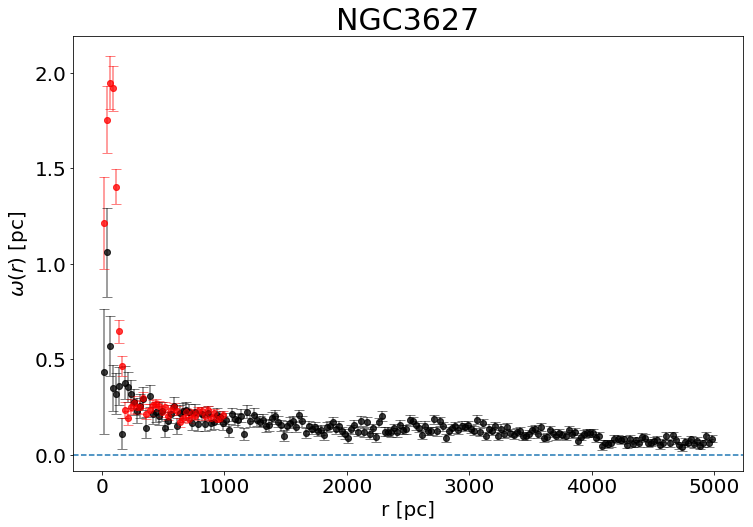

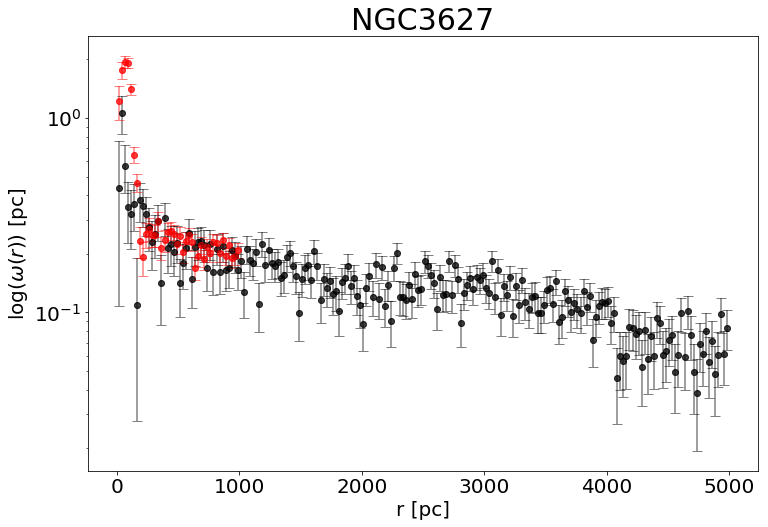

In [21]:


fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(r0obs, w0obs, ew0obs, fmt="o", color='black', capsize=5, alpha=0.5)
ax.plot(r0obs, w0obs, 'o', color='black', alpha=0.5)
ax.errorbar(r0, w0, ew0, fmt="o", color='red', capsize=5, alpha=0.5)
ax.plot(r0, w0, 'o', color='red', alpha=0.5)
#ax.plot(r1, w1, '-o')
#ax.plot(r2, w2, '-o')
#ax.plot(r3, w3, '-o')
#ax.set_xlim(0, 250)
ax.axhline(y=0, linestyle='--')
plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
#ax.set_yscale('log')
plt.savefig('./plots/'+galaxy+'_corr_full_model.png')
#plt.show()


fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(r0obs, w0obs, ew0obs, fmt="o", color='black', capsize=5, alpha=0.5)
ax.plot(r0obs, w0obs, 'o', color='black', alpha=0.5)
ax.errorbar(r0, w0, ew0, fmt="o", color='red', capsize=5, alpha=0.5)
ax.plot(r0, w0, 'o', color='red', alpha=0.5)
#ax.plot(r1, w1, '-o')
#ax.plot(r2, w2, '-o')
#ax.plot(r3, w3, '-o')
#ax.set_xlim(0, 250)
#ax.set_ylim(1e-3, 1e1)
ax.axhline(y=0, linestyle='--')
plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'log($\omega(r)$) [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
ax.set_yscale('log')
plt.savefig('./plots/'+galaxy+'_corr_log_model.png')
#plt.show()

